In [1]:
import math
import matplotlib as mpl
import matplotlib.pylab as plt
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook
import numpy as np
import palettable
import h5py

import pic_information
from cori_3d import div0, find_nearest
from json_functions import read_data_from_json
from scipy import interpolate

plt.style.use("seaborn-deep")
mpl.rc('text', usetex=True)
mpl.rc('font', **{'family': 'sans-serif'})
mpl.rcParams['text.latex.preamble'] = \
[r"\usepackage{amsmath, bm}",
 r"\DeclareMathAlphabet{\mathsfit}{\encodingdefault}{\sfdefault}{m}{sl}",
 r"\SetMathAlphabet{\mathsfit}{bold}{\encodingdefault}{\sfdefault}{bx}{sl}",
 r"\newcommand{\tensorsym}[1]{\bm{\mathsfit{#1}}}"]
COLORS = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

#### Get the PIC simulation information

In [2]:
pic_run = "3D-Lx150-bg0.2-150ppc-2048KNL"
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/Cori_runs/' + pic_run + '/'
tframe = 20
tstart = 0
tend = 40
nframes = tend - tstart + 1
picinfo_fname = '../data/pic_info/pic_info_' + pic_run + '.json'
pic_info = read_data_from_json(picinfo_fname)
nx, ny, nz = pic_info.nx, pic_info.ny, pic_info.nz
xdi = pic_info.x_di
ydi = pic_info.y_di
zdi = pic_info.z_di
xdi_smooth = xdi[::2]
ydi_smooth = ydi[::2]
zdi_smooth = zdi[::2]
xmin, xmax = xdi[0], xdi[-1]
ymin, ymax = ydi[0], ydi[-1]
zmin, zmax = zdi[0], zdi[-1]
smime = math.sqrt(pic_info.mime)
dx_de = pic_info.dx_di * smime * 2
dy_de = pic_info.dy_di * smime * 2
dz_de = pic_info.dz_di * smime * 2

Reading ../data/pic_info/pic_info_3D-Lx150-bg0.2-150ppc-2048KNL.json


In [3]:
species = 'e'
species_name = 'electron' if species == 'e' else 'ion'
pmass = 1 if species == 'e' else pic_info.mime
vth = pic_info.vthe if species == 'e' else pic_info.vthi
gama = 1.0 / math.sqrt(1.0 - 3 * vth**2)
eth = (gama - 1) * pmass

# Electric Field

In [30]:
def read_efield(tframe):
    """Read electric field at one time frame
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/ex_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ey = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ez_" + str(tindex) + ".gda"
    ez = np.fromfile(fname, dtype=np.float32)
    abse = np.sqrt(ex**2 + ey**2 + ez**2)
    abse1 = abse.reshape((nz//2, ny//2, nx//2))
    return abse1

In [48]:
abse1 = read_efield(10)
abse2 = read_efield(20)

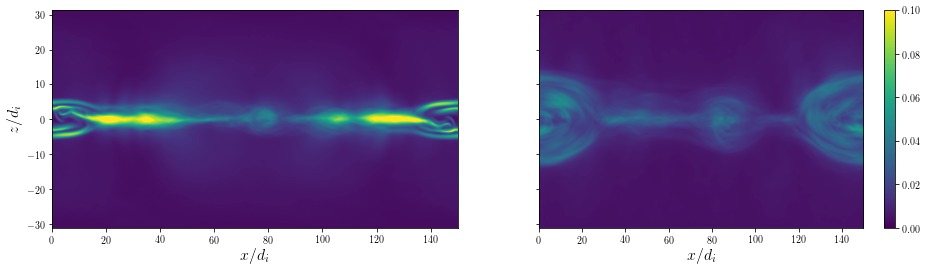

In [49]:
emin, emax = 0.0, 0.1
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,4))
img1 = ax1.imshow(np.mean(abse1, axis=1), vmin=emin, vmax=emax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
img2 = ax2.imshow(np.mean(abse2, axis=1), vmin=emin, vmax=emax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
lx1 = ax1.set_xlabel(r'$x/d_i$', fontsize=16)
ly1 = ax1.set_ylabel(r'$z/d_i$', fontsize=16)
lx2 = ax2.set_xlabel(r'$x/d_i$', fontsize=16)
cbar = fig.colorbar(img2, ax=ax2)

## Averger along x

In [50]:
def get_efield_yz(tframe):
    """Get the electric field averaged along x
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/ex_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ey = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ez_" + str(tindex) + ".gda"
    ez = np.fromfile(fname, dtype=np.float32)
    ex = ex.reshape((nz//2, ny//2, nx//2))
    ey = ey.reshape((nz//2, ny//2, nx//2))
    ez = ez.reshape((nz//2, ny//2, nx//2))
    ex_yz = np.mean(ex, axis=2)
    ey_yz = np.mean(ey, axis=2)
    ez_yz = np.mean(ez, axis=2)
    return (ex_yz, ey_yz, ez_yz)

In [51]:
def plot_efield_yz(tframe):
    """Plot the electric field averaged along x
    """
    ex_yz, ey_yz, ez_yz = get_efield_yz(tframe)
    fig = plt.figure(figsize=[9, 2.5])
    rect = [0.06, 0.15, 0.275, 0.8]
    hgap, vgap = 0.01, 0.02
    ax = fig.add_axes(rect)
    img1 = ax.imshow(ex_yz, vmin=-0.02, vmax=0.02,
                     extent=[ymin, ymax, zmin, zmax],
                     cmap=plt.cm.seismic, aspect='auto',
                     origin='lower', interpolation='bicubic')
    ax.set_xlabel(r'$y/d_i$', fontsize=10)
    ax.set_ylabel(r'$z/d_i$', fontsize=10)
    ax.tick_params(bottom=True, top=False, left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.tick_params(labelsize=8)
    ax.text(0.03, 0.95, r'$E_x$', color='k', fontsize=10,
             bbox=dict(facecolor='none', alpha=1.0,
                       edgecolor='none', pad=10.0),
             horizontalalignment='left', verticalalignment='top',
             transform=ax.transAxes)

    rect[0] += rect[2] + hgap
    ax = fig.add_axes(rect)
    img1 = ax.imshow(ey_yz, vmin=-0.02, vmax=0.02,
                     extent=[ymin, ymax, zmin, zmax],
                     cmap=plt.cm.seismic, aspect='auto',
                     origin='lower', interpolation='bicubic')
    ax.set_xlabel(r'$y/d_i$', fontsize=10)
    ax.tick_params(axis='y', labelleft=False)
    ax.tick_params(bottom=True, top=False, left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.tick_params(labelsize=8)
    ax.text(0.03, 0.95, r'$E_y$', color='k', fontsize=10,
             bbox=dict(facecolor='none', alpha=1.0,
                       edgecolor='none', pad=10.0),
             horizontalalignment='left', verticalalignment='top',
             transform=ax.transAxes)

    rect[0] += rect[2] + hgap
    ax = fig.add_axes(rect)
    img1 = ax.imshow(ez_yz, vmin=-0.02, vmax=0.02,
                     extent=[ymin, ymax, zmin, zmax],
                     cmap=plt.cm.seismic, aspect='auto',
                     origin='lower', interpolation='bicubic')
    ax.set_xlabel(r'$y/d_i$', fontsize=10)
    ax.tick_params(axis='y', labelleft=False)
    ax.tick_params(bottom=True, top=False, left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.tick_params(labelsize=8)
    ax.text(0.03, 0.95, r'$E_z$', color='k', fontsize=10,
             bbox=dict(facecolor='none', alpha=1.0,
                       edgecolor='none', pad=10.0),
             horizontalalignment='left', verticalalignment='top',
             transform=ax.transAxes)

    rect_cbar = np.copy(rect)
    rect_cbar[0] += rect[2] + hgap
    rect_cbar[2] = 0.02
    cbar_ax = fig.add_axes(rect_cbar)
    cbar = fig.colorbar(img1, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=8)
    fname = '../img/cori_3d/efield_yz/efield_yz_' + str(tframe) + '.jpg'
    fig.savefig(fname, dpi=200)
    plt.close()

In [52]:
# for tframe in range(tstart, tend + 1):
#     plot_efield_yz(tframe)

# Voltage drop

In [53]:
def voltage_y(tframe):
    """Plot voltage drop along y
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ey = np.fromfile(fname, dtype=np.float32)
    ey = ey.reshape((nz//2, ny//2, nx//2))
    ey_yz = np.mean(ey, axis=2)
    vol_y = np.sum(ey_yz, axis=1) * dy_de
    fig = plt.figure(figsize=[3.5, 2.5])
    rect = [0.15, 0.15, 0.8, 0.8]
    hgap, vgap = 0.01, 0.02
    ax = fig.add_axes(rect)
    ax.plot(zdi_smooth, vol_y)
    ax.set_xlim([zmin, zmax])
    ax.set_xlabel(r'$z/d_i$', fontsize=10)
    ax.set_ylabel(r'Voltage$(m_ec^2/e)$', fontsize=10)
    ax.tick_params(bottom=True, top=False, left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.tick_params(labelsize=8)

    fname = '../img/cori_3d/vol_y/vol_y_' + str(tframe) + '.pdf'
    fig.savefig(fname)
    plt.close()

In [54]:
# for tframe in range(tstart, tend + 1):
#     voltage_y(tframe)

# Current Density

In [55]:
def read_absj(tframe):
    """Read current density at one time frame
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/absJ_" + str(tindex) + ".gda"
    absJ = np.fromfile(fname, dtype=np.float32)
    absJ1 = absJ.reshape((nz//2, ny//2, nx//2))
    return absJ1

In [56]:
absJ1 = read_absj(10)
absJ2 = read_absj(20)

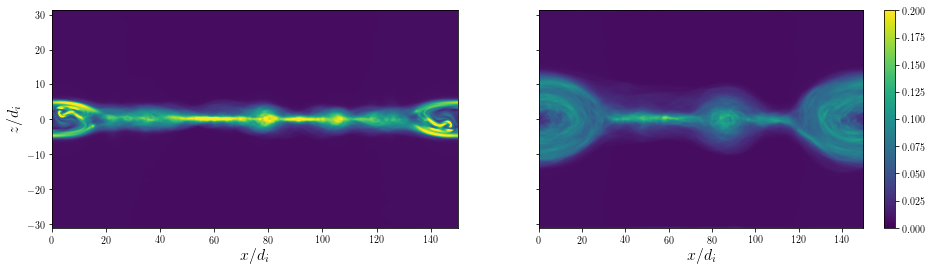

In [57]:
jmin, jmax = 0.0, 0.2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,4))
img1 = ax1.imshow(np.mean(absJ1, axis=1), vmin=jmin, vmax=jmax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
img2 = ax2.imshow(np.mean(absJ2, axis=1), vmin=jmin, vmax=jmax,
                  extent=[xmin, xmax, zmin, zmax],
                  cmap=plt.cm.viridis, aspect='auto',
                  origin='lower', interpolation='bicubic')
lx1 = ax1.set_xlabel(r'$x/d_i$', fontsize=16)
ly1 = ax1.set_ylabel(r'$z/d_i$', fontsize=16)
lx2 = ax2.set_xlabel(r'$x/d_i$', fontsize=16)
cbar = fig.colorbar(img2, ax=ax2)

# $J\cdot E$, where $J$ is the total current density

In [58]:
def get_jdote(tframe):
    """Get plasma energization j.E
    """
    tindex = pic_info.particle_interval * tframe
    fname = pic_run_dir + "data-smooth/jx_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ex_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote = jx * ex
    fname = pic_run_dir + "data-smooth/jy_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ey_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote += jx * ex
    fname = pic_run_dir + "data-smooth/jz_" + str(tindex) + ".gda"
    jx = np.fromfile(fname, dtype=np.float32)
    fname = pic_run_dir + "data-smooth/ez_" + str(tindex) + ".gda"
    ex = np.fromfile(fname, dtype=np.float32)
    jdote += jx * ex
    jdote1 = jdote.reshape((nz//2, ny//2, nx//2))
    return jdote1

In [59]:
jdote1 = get_jdote(10)
jdote2 = get_jdote(20)
jdote3 = get_jdote(30)

In [60]:
jdote1_x = np.sum(np.mean(jdote1, axis=1), axis=0)
jdote2_x = np.sum(np.mean(jdote2, axis=1), axis=0)
jdote3_x = np.sum(np.mean(jdote3, axis=1), axis=0)

In [61]:
def plot_jdote(axs, jdote1, jdote1_x):
    """Plot jdote for one time frame
    """
    jemin, jemax = -0.001, 0.001
    img1 = axs[0].imshow(np.mean(jdote1, axis=1), vmin=jemin, vmax=jemax,
                         extent=[xmin, xmax, zmin, zmax],
                         cmap=plt.cm.seismic, aspect='auto',
                         origin='lower', interpolation='bicubic')
    img1 = axs[1].imshow(np.mean(jdote1, axis=0), vmin=jemin, vmax=jemax,
                         extent=[xmin, xmax, zmin, zmax],
                         cmap=plt.cm.seismic, aspect='auto',
                         origin='lower', interpolation='bicubic')
    p1, = axs[2].plot(xdi_smooth, jdote1_x)
    p2, = axs[2].plot([xmin, xmax], [0, 0])
    lim1 = axs[2].set_xlim([xmin, xmax])

Text(0,0.5,'$y/d_i$')

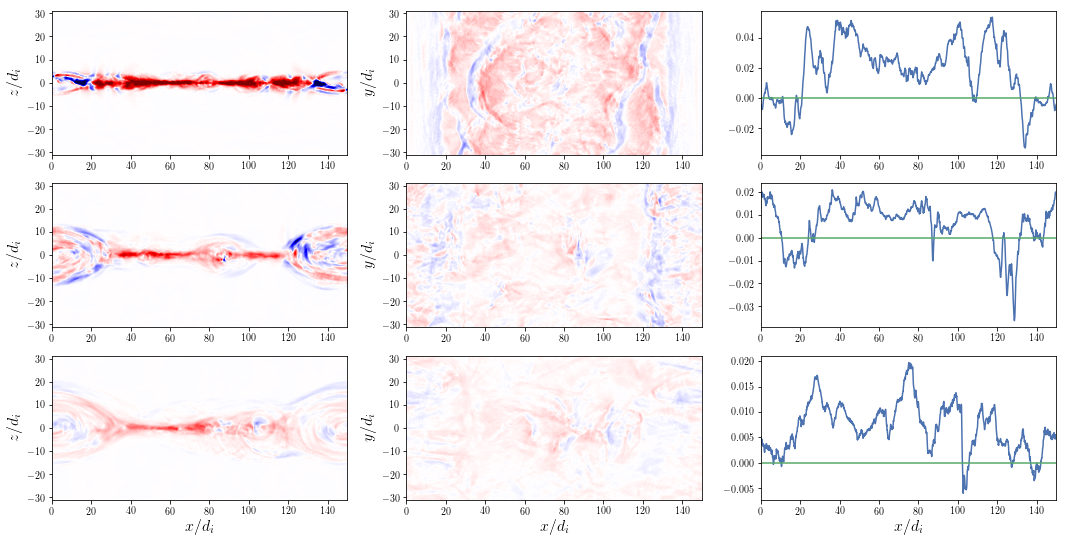

In [62]:
fig, axs = plt.subplots(3, 3, figsize=(18,9))
plot_jdote(axs[0], jdote1, jdote1_x)
plot_jdote(axs[1], jdote2, jdote2_x)
plot_jdote(axs[2], jdote3, jdote3_x)
axs[2, 0].set_xlabel(r'$x/d_i$', fontsize=16)
axs[2, 1].set_xlabel(r'$x/d_i$', fontsize=16)
axs[2, 2].set_xlabel(r'$x/d_i$', fontsize=16)
axs[0, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[1, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[2, 0].set_ylabel(r'$z/d_i$', fontsize=16)
axs[0, 1].set_ylabel(r'$y/d_i$', fontsize=16)
axs[1, 1].set_ylabel(r'$y/d_i$', fontsize=16)
axs[2, 1].set_ylabel(r'$y/d_i$', fontsize=16)

# The distribution of electric field

In [22]:
# fdir = '../data/cori_3d/abse_dist/' + pic_run + '/'
# nacc = np.zeros(nframes)
# tframes = range(tstart, tend + 1)
# es = 0.05
# for tframe in range(tstart, tend + 1):
#     fname = fdir + "abse_dist_" + str(tframe) + ".dat"
#     earray = np.fromfile(fname)
#     nbins = earray.shape[0] // 2
#     ebins = earray[:nbins]
#     edist = earray[nbins:]
#     color = plt.cm.seismic((tframe - tstart)/float(nframes), 1)
#     plt.semilogy(ebins, edist, color=color)
#     nacc[tframe - tstart] = np.sum(edist[ebins > es])
# plt.grid(True)

In [23]:
# species = 'e'
# if species == 'e':
#     dkene = pic_info.dkene_e
# else:
#     dkene = pic_info.dkene_i

In [24]:
# tfields = pic_info.tfields
# tenergy = pic_info.tenergy
# nacc_norm = nacc / nacc.max()
# dkene_norm = dkene / dkene.max()
# plt.plot(tfields, nacc_norm, label='$E>' + str(es) + '$')
# plt.plot(tenergy, dkene_norm, label='Energy conversion rate')
# plt.legend(loc=3, prop={'size': 16}, ncol=1,
#           shadow=False, fancybox=False, frameon=False)

In [25]:
# dtf = pic_info.dt_fields * pic_info.dtwpe / pic_info.dtwci
# plt.plot(tfields[2:], np.gradient(nacc[2:], dtf)/nacc[2:])
# plt.plot([tfields[0], tfields[-1]], [0, 0])

# Particle number density

In [63]:
tframe = 10
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne1 = ne.reshape((nz//2, ny//2, nx//2))

tframe = 20
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne2 = ne.reshape((nz//2, ny//2, nx//2))

tframe = 30
tindex = pic_info.particle_interval * tframe
fname = pic_run_dir + "data-smooth/ne_" + str(tindex) + ".gda"
ne = np.fromfile(fname, dtype=np.float32)
ne3 = ne.reshape((nz//2, ny//2, nx//2))

In [64]:
nx2, ny2, nz2 = nz//2, ny//2, nx//2
ne1_x = np.sum(np.sum(ne1[nz2//4:nz2*3//4], axis=0), axis=0)
ne2_x = np.sum(np.sum(ne2[nz2//4:nz2*3//4], axis=0), axis=0)
ne3_x = np.sum(np.sum(ne3[nz2//4:nz2*3//4], axis=0), axis=0)

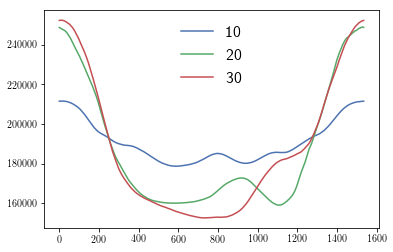

In [65]:
plt.plot(ne1_x, label='10')
plt.plot(ne2_x, label='20')
plt.plot(ne3_x, label='30')
plt.legend(loc=9, prop={'size': 16}, ncol=1,
          shadow=False, fancybox=False, frameon=False)

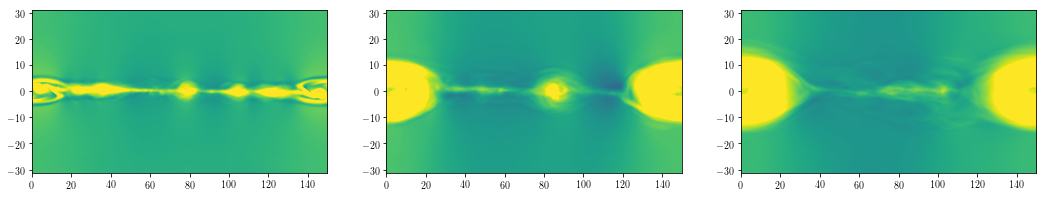

In [66]:
nmin, nmax = 0, 1.5
fig, axs = plt.subplots(1, 3, figsize=(18,3))
img1 = axs[0].imshow(np.mean(ne1, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')
img2 = axs[1].imshow(np.mean(ne2, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')
img3 = axs[2].imshow(np.mean(ne3, axis=1), vmin=nmin, vmax=nmax,
                     extent=[xmin, xmax, zmin, zmax],
                     cmap=plt.cm.viridis, aspect='auto',
                     origin='lower', interpolation='bicubic')

# High-energy particle density

In [67]:
tframe = 10
tindex = pic_info.particle_interval * tframe
ne1_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne1_high += ne.reshape((nz//4, ny//4, nx//4))
    
tframe = 15
tindex = pic_info.particle_interval * tframe
ne2_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne2_high += ne.reshape((nz//4, ny//4, nx//4))
    
tframe = 20
tindex = pic_info.particle_interval * tframe
ne3_high = np.zeros((nz//4, ny//4, nx//4))
for band in range(2, 7):
    fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
    ne = np.fromfile(fname, dtype=np.float32)
    ne3_high += ne.reshape((nz//4, ny//4, nx//4))

In [70]:
ne1_high_x = np.sum(np.sum(ne1_high, axis=0), axis=0)
ne2_high_x = np.sum(np.sum(ne2_high, axis=0), axis=0)
ne3_high_x = np.sum(np.sum(ne3_high, axis=0), axis=0)

In [3]:
plt.plot(ne1_high_x, label='10')
plt.plot(ne2_high_x, label='15')
plt.plot(ne3_high_x, label='20')
plt.legend(loc=9, prop={'size': 16}, ncol=1,
          shadow=False, fancybox=False, frameon=False)
plt.grid(True)

NameError: name 'ne1_high_x' is not defined

In [72]:
xth = 100
ne1_high_xb = np.sum(ne1_high_x) - np.sum(ne1_high_x[xth:-xth])
ne2_high_xb = np.sum(ne2_high_x) - np.sum(ne2_high_x[xth:-xth])
ne3_high_xb = np.sum(ne3_high_x) - np.sum(ne3_high_x[xth:-xth])
print(ne1_high_xb, ne2_high_xb, ne3_high_xb)

3202.091403641076 24406.069501124686 37795.2145566738


In [73]:
nhigh_min = 0
nhigh_max = 0.002

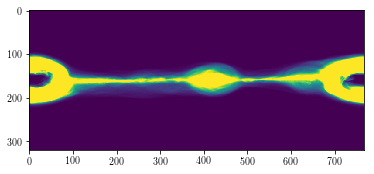

In [74]:
plt.imshow(np.mean(ne2_high, axis=1),
           vmin=nhigh_min, vmax=nhigh_max,
           cmap=plt.cm.viridis)

In [75]:
ne1_high_z = np.sum(np.sum(ne1_high, axis=2), axis=1)
ne2_high_z = np.sum(np.sum(ne2_high, axis=2), axis=1)
ne3_high_z = np.sum(np.sum(ne3_high, axis=2), axis=1)

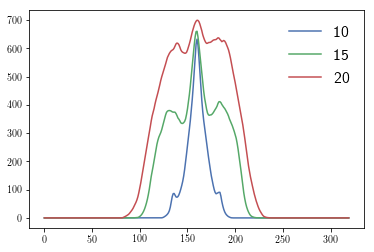

In [76]:
plt.plot(ne1_high_z, label='10')
plt.plot(ne2_high_z, label='15')
plt.plot(ne3_high_z, label='20')
plt.legend(loc=1, prop={'size': 16}, ncol=1,
           shadow=False, fancybox=False, frameon=False)

In [4]:
# ntf = pic_info.ntf
# nbands = 7
# ne_high_x = np.zeros((ntf-1, nbands, nx//4))
# for tframe in range(ntf-1):
#     tindex = pic_info.particle_interval * (tframe + 1)
#     for band in range(nbands):
#         fname = pic_run_dir + "data-smooth2/ne_" + str(band) + "_" + str(tindex) + ".gda"
#         ne = np.fromfile(fname, dtype=np.float32)
#         ne = ne.reshape((nz//4, ny//4, nx//4))
#         ne_high_x[tframe, band, :] = np.sum(np.sum(ne, axis=0), axis=0)
fname = pic_run_dir + "data-smooth2/ne_all_bands.gda"
# ne_high_x.tofile(fname)
ne_high_x = np.fromfile(fname)
ntf = 41
ne_high_x = ne_high_x.reshape([ntf-1, -1, nx//4])

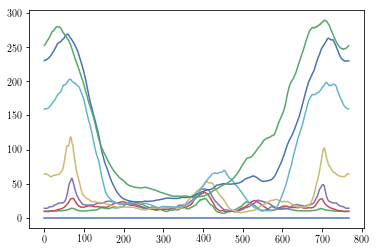

In [5]:
ne_tot_x = np.sum(ne_high_x[:, 2:, :], axis=1)
p1, = plt.plot(ne_tot_x[0])
p1, = plt.plot(ne_tot_x[8])
p1, = plt.plot(ne_tot_x[9])
p2, = plt.plot(ne_tot_x[10])
p2, = plt.plot(ne_tot_x[12])
p3, = plt.plot(ne_tot_x[20])
p4, = plt.plot(ne_tot_x[30])
p5, = plt.plot(ne_tot_x[39])

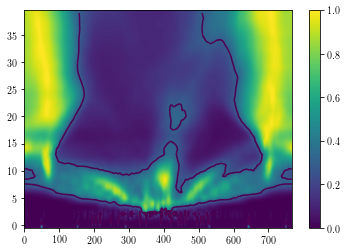

In [6]:
ne_tot_x_norm = (ne_tot_x.T / np.max(ne_tot_x, axis=1)).T
img = plt.imshow(ne_tot_x_norm, cmap=plt.cm.viridis,
                 vmin=0, vmax=1.0, aspect='auto',
                 origin='lower', interpolation='bicubic')
cs = plt.contour(ne_tot_x_norm, levels=[0.3])
cbar = plt.colorbar(img)
# plt.plot([200, 80], [22, 12], color='grey')
# plt.plot([200, 220], [22, 39], color='grey')
# plt.plot([80, 260], [8, 39], color='grey')
# plt.plot([720, 550], [8, 22], color='grey')
# plt.plot([550, 600], [22, 39], color='grey')

Maximum length 1050
Minimum time 5.969726


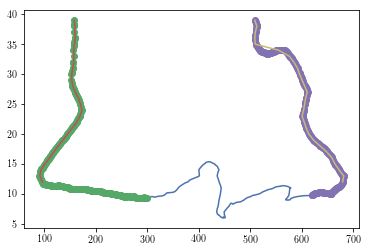

In [7]:
for cl in cs.collections:
    len_max = 0
    max_index = 0
    for index, p in enumerate(cl.get_paths()):
        v = p.vertices
        if len(v) > len_max and np.min(v[:, 0] > 10):
            len_max = len(v)
            max_index = index
v = cl.get_paths()[max_index].vertices
print("Maximum length %d" % len_max)
print("Minimum time %f" % np.min(v[:, 1]))
if 'bg0.2' in pic_run:
    plt.plot(v[:, 0], v[:, 1])
    f = interpolate.interp1d(v[700:, 1], v[700:, 0])
    ynew = np.arange(12, 40, 1)
    xnew1 = np.ceil(f(ynew)).astype(int)
    plt.plot(v[700:, 0], v[700:, 1], 'o', xnew1, ynew, '-')
    f = interpolate.interp1d(v[:300, 1], v[:300, 0])
    ynew = np.arange(12, 40, 1)
    xnew2 = np.floor(f(ynew)).astype(int)
    plt.plot(v[:300, 0], v[:300, 1], 'o', xnew2, ynew, '-')
else:
    plt.plot(v[:, 0], v[:, 1])
    f = interpolate.interp1d(v[600:, 1], v[600:, 0])
    ynew = np.arange(12, 40, 1)
    xnew1 = np.ceil(f(ynew)).astype(int)
    plt.plot(v[600:, 0], v[600:, 1], 'o', xnew1, ynew, '-')
    f = interpolate.interp1d(v[:500, 1], v[:500, 0])
    ynew = np.arange(12, 40, 1)
    xnew2 = np.floor(f(ynew)).astype(int)
    plt.plot(v[:500, 0], v[:500, 1], 'o', xnew2, ynew, '-')

In [8]:
# High-energy particles close to the boundary
ne_high_xb = []
ntf, nbands, nxr = ne_high_x.shape
xth = 20
xth1 = xth2 = 1
xth1s = []
xth2s = []
for tframe in range(ntf):
    ne_data = ne_high_x[tframe]
#     if tframe < 8:
#         xth += 0
#     elif tframe >= 8:
#         t0 = tframe - 8
#         xth += int(12 - 0.3 * t0)
#     elif tframe >= 10 and tframe <= 20:
#         xth = (tframe - 15) * 10 + 100
#     else:
#         xth = (tframe - 20) * 2 + 150

#     if tframe < 8:
#         xth1 += 0
#         xth2 += 0
#     elif tframe >= 8 and tframe <= 22:
#         xth1 = (tframe - 8) * 6 + 80
#         xth2 = (tframe - 8) * 11 + 68
#     else:
#         xth1 = (tframe - 8) * 6 + 80
#         xth2 = (tframe - 22) * (-3) + 218

    if tframe >= 12:
        xth1 = xnew1[tframe - 12]
        xth2 = nxr - xnew2[tframe - 12]
    else:
        xth1 = xnew1[0] // 12 * tframe
        xth2 = (nxr - xnew2[0]) // 12 * tframe
#     print(tframe, xth, xth1, xth2)
    xth1s.append(xth1)
    xth2s.append(xth2)
#     tmp = np.sum(ne_data, axis=1) - np.sum(ne_data[:, xth:-xth], axis=1)
    tmp = np.sum(ne_data, axis=1) - np.sum(ne_data[:, xth1:-xth2], axis=1)
    ne_high_xb.append(tmp)
ne_high_xb = np.asarray(ne_high_xb)

In [9]:
# ne_high_x.tofile(pic_run_dir + 'agu18_data/ne_high_x.dat')
# ne_high_xb.tofile(pic_run_dir + 'agu18_data/ne_high_xb.dat')

In [10]:
# # High-energy particles close to the boundary (different method)
# ne_high_xb = []
# ntf, nbands, nxr = ne_high_x.shape
# xth1 = xth2 = 20
# for tframe in range(ntf):
#     ne_data = ne_high_x[tframe-1]
#     nsum = np.sum(ne_data[2:, :], axis=0)
#     if tframe < 8:
#         xth1 += 0
#         xth2 += 0
#     elif tframe >= 8:
#         nmax = np.max(nsum)
#         nmin = np.min(nsum)
#         navg = np.mean(nsum)
#         xth1 = np.argmax(nsum < 0.5 * navg)
#         xth2 = np.argmax(nsum[::-1] < 0.5 * navg)
# #         print(xth1, xth2)
#     tmp = np.sum(ne_data, axis=1) - np.sum(ne_data[:, xth1:-xth2], axis=1)
#     ne_high_xb.append(tmp)
# ne_high_xb = np.asarray(ne_high_xb)

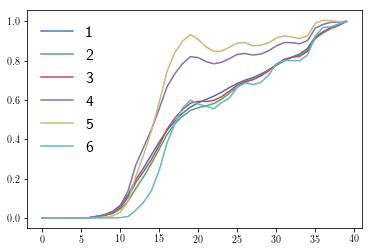

In [11]:
ne_high_ratio = ne_high_xb/ne_high_xb[-1]
for band in range(1, nbands):
    plt.plot(ne_high_ratio[:, band], label=str(band))
leg1 = plt.legend(loc=2, prop={'size': 16}, ncol=1,
                  shadow=False, fancybox=False, frameon=False)

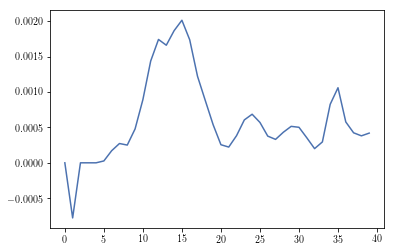

In [12]:
ne_high_tot = np.sum(np.sum(ne_high_x[:, 2:], axis=2), axis=1)
dtf = pic_info.dt_fields * pic_info.dtwpe / pic_info.dtwci
ne_high_ratio20 = np.sum(ne_high_xb[:, 2:], axis=1)
ne_high_acc = ne_high_tot - ne_high_ratio20
esc_rate = div0(np.gradient(ne_high_ratio20, dtf), ne_high_acc)
plt.plot(esc_rate)
# plt.plot(ne_high_ratio20)
# plt.plot(ne_high_acc)
# plt.plot(np.diff(ne_high_tot))
# plt.plot(np.sum(ne_high_x, axis=2)[:, 1:])
# plt.grid(True)

# High-energy particle density obtained from local spectrum

In [26]:
emin, emax = 1E-6, 1E4
nband = 1000
dloge = (math.log10(emax) - math.log10(emin)) / (nband - 1)
emin0 = 10**(math.log10(emin) - dloge)
ebins = np.logspace(math.log10(emin0), math.log10(emax), nband+1)
ebins /= eth
ebins_mid = (ebins[:-1] + ebins[1:]) * 0.5
ene1, ene2 = 50, 200
eindex1, e1 = find_nearest(ebins, ene1)
eindex2, e2 = find_nearest(ebins, ene2)

In [18]:
# nptl_high_x = []
# for tindex in range(0, 88681, 2217):
#     fname = (pic_run_dir + 'spectrum_along_x/spectrum_' +
#              species_name + '_' + str(tindex) + '.h5')
#     with h5py.File(fname, 'r') as fh:
#         dset = fh['spectrum']
#         sz = dset.shape
#         fdata = np.zeros(sz)
#         dset.read_direct(fdata)
#     fdata = np.squeeze(fdata)
#     nptl_high_x.append(np.sum(fdata[:, (3+eindex1):], axis=1))
# nptl_high_x = np.asarray(nptl_high_x)
# fdir = '../data/nptl_high_x/'
# fname = fdir + 'nptl_high_x_' + pic_run + '.dat'
# nptl_high_x.tofile(fname)

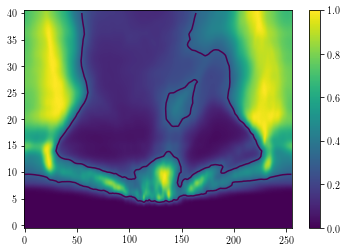

In [19]:
fdir = '../data/nptl_high_x/'
fname = fdir + 'nptl_high_x_' + pic_run + '.dat'
fdata = np.fromfile(fname)
nptl_high_x = fdata.reshape([-1, 256])
nptl_high_x_norm = div0(nptl_high_x.T, np.max(nptl_high_x, axis=1)).T
img = plt.imshow(nptl_high_x_norm, cmap=plt.cm.viridis,
                 vmin=0, vmax=1, aspect='auto',
                 origin='lower', interpolation='bicubic')
level_threshold = 0.3 if 'bg0.2' in pic_run else 0.4
cs = plt.contour(nptl_high_x_norm, levels=[level_threshold])
cbar = plt.colorbar(img)
# img = plt.imshow(nptl_high_x, cmap=plt.cm.viridis,
#                  aspect='auto',
#                  origin='lower', interpolation='bicubic')

Maximum length 429
Minimum time 7.211664


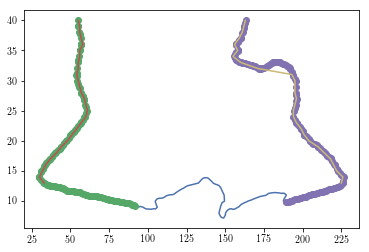

In [20]:
for cl in cs.collections:
    len_max = 0
    max_index = 0
    for index, p in enumerate(cl.get_paths()):
        v = p.vertices
        if len(v) > len_max and np.min(v[:, 0] > 10):
            len_max = len(v)
            max_index = index
v = cl.get_paths()[max_index].vertices
print("Maximum length %d" % len_max)
print("Minimum time %f" % np.min(v[:, 1]))
if 'bg0.2' in pic_run:
    tframe_threshold = 13
    plt.plot(v[:, 0], v[:, 1])
    f = interpolate.interp1d(v[290:, 1], v[290:, 0])
    ynew = np.arange(tframe_threshold, 41, 1)
    xnew1 = np.ceil(f(ynew)).astype(int)
    plt.plot(v[290:, 0], v[290:, 1], 'o', xnew1, ynew, '-')
    f = interpolate.interp1d(v[:160, 1], v[:160, 0])
    ynew = np.arange(tframe_threshold, 41, 1)
    xnew2 = np.floor(f(ynew)).astype(int)
    plt.plot(v[:160, 0], v[:160, 1], 'o', xnew2, ynew, '-')
else:
    tframe_threshold = 15
    plt.plot(v[:, 0], v[:, 1])
    f = interpolate.interp1d(v[250:, 1], v[250:, 0])
    ynew = np.arange(tframe_threshold, 41, 1)
    xnew1 = np.ceil(f(ynew)).astype(int)
    plt.plot(v[250:, 0], v[250:, 1], 'o', xnew1, ynew, '-')
    f = interpolate.interp1d(v[:170, 1], v[:170, 0])
    ynew = np.arange(tframe_threshold, 41, 1)
    xnew2 = np.floor(f(ynew)).astype(int)
    plt.plot(v[:160, 0], v[:160, 1], 'o', xnew2, ynew, '-')

In [27]:
# High-energy particles close to the boundary
nptl_high_xb = []
xth1 = xth2 = 1
xth1s = []
xth2s = []
for tframe in range(41):
    nptl_data = nptl_high_x[tframe]
    if tframe >= tframe_threshold:
        xth1 = xnew1[tframe - tframe_threshold]
        xth2 = 256 - xnew2[tframe - tframe_threshold]
    else:
        xth1 = xnew1[0] // tframe_threshold * tframe
        xth2 = (256 - xnew2[0]) // tframe_threshold * tframe
#     print(tframe, xth1, xth2)
    xth1s.append(xth1)
    xth2s.append(xth2)
    tmp = np.sum(nptl_data) - np.sum(nptl_data[xth1:-xth2])
    nptl_high_xb.append(tmp)
nptl_high_xb = np.asarray(nptl_high_xb)

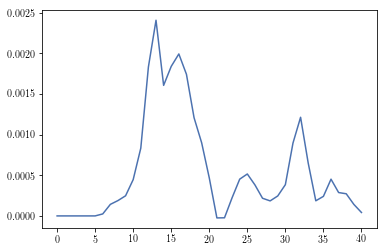

In [28]:
nptl_high_tot = np.sum(nptl_high_x, axis=1)
dtf = pic_info.dt_fields * pic_info.dtwpe / pic_info.dtwci
nptl_high_acc = nptl_high_tot - nptl_high_xb
esc_rate = div0(np.gradient(nptl_high_xb, dtf), nptl_high_acc)
plt.plot(esc_rate)

In [29]:
# particle acceleration rate
species = 'e'
fpath = '../data/particle_interp/' + pic_run + '/'
falpha = []
nframes = 40

for tframe in range(1, 41):
    tindex = pic_info.particle_interval * tframe
    fname = fpath + "particle_energization_" + species + "_" + str(tindex) + ".gda"
    fdata = np.fromfile(fname, dtype=np.float32)
    nbins = int(fdata[0])
    nbinx = int(fdata[1])
    nvar = int(fdata[2])
    ebins = fdata[3:nbins+3]
    fbins = fdata[nbins+3:].reshape((nvar, nbinx, nbins))
    falpha.append(fbins)
falpha = np.asarray(falpha)
ebins /= eth

In [30]:
# xth1s_norm = np.asarray(xth1s) // 3
# xth2s_norm = np.asarray(xth2s) // 3
xth1s_norm = np.asarray(xth1s)
xth2s_norm = np.asarray(xth2s)

Two chosen energy band: 51.76071 206.0631


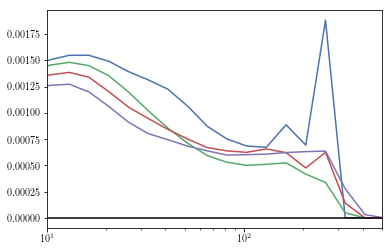

In [35]:
# alpha_tot = np.sum(np.sum(falpha[:, 1:3, :, :], axis=1), axis=1) / np.sum(falpha[:, 0, :, :], axis=1)
# alpha_tot = div0(np.sum(falpha[:, 2, :, :], axis=1), np.sum(falpha[:, 0, :, :], axis=1))
alpha_tot = []
for i in range(40):
    xs, xe = xth1s_norm[i], xth2s_norm[i]
    if xe == 0:
        xe = 1
#     alpha_t = div0(np.sum(falpha[i, 2, xs:-xe, :], axis=0),
#                    np.sum(falpha[i, 0, xs:-xe, :], axis=0))
#     alpha_t = div0(np.sum(np.sum(falpha[i, 1:3, xs:-xe, :], axis=0), axis=0),
#                    np.sum(falpha[i, 0, xs:-xe, :], axis=0))
    alpha_t = div0(np.sum(np.sum(falpha[i, 5:6, xs:-xe, :], axis=0), axis=0),
                   np.sum(falpha[i, 0, xs:-xe, :], axis=0))
    alpha_tot.append(alpha_t)
alpha_tot = np.asarray(alpha_tot)
eindex1, e1 = find_nearest(ebins, ene1)
eindex2, e2 = find_nearest(ebins, ene2)
print('Two chosen energy band:', e1, e2)
p1 = plt.semilogx(ebins, alpha_tot[6:10].T)
p2 = plt.semilogx([1, 500], [0, 0], color='k')
l1 = plt.xlim([10, 5E2])
# l2 = plt.ylim([-0.0001, 0.0004])

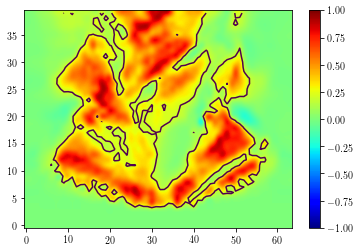

In [37]:
falpha_reduced = np.sum(falpha.reshape([nframes, nvar, -1, 4, nbins]), axis=3)
falpha_tot = np.sum(falpha_reduced[:, 5:6, :, :], axis=1)  # Parallel and perpendicular E-field
# falpha_tot = falpha_reduced[:, 2, :, :]
falpha_x = div0(falpha_tot, falpha_reduced[:, 0, :, :])
falpha_x_mean = np.mean(falpha_x[:, :, eindex1:eindex2], axis=2)
tstart, tend = 6, 20
ntframes = tend - tstart + 1
colors_jet = plt.cm.jet(np.arange(ntframes) / float(ntframes), 1)
# for tframe in range(tstart, tend + 1):
#     p1, = plt.plot(falpha_x_mean[tframe].T/np.max(falpha_x_mean[tframe]),
#                    color=colors_jet[tframe - tstart],
#                    marker='*')
# print(np.max(falpha_x_mean, axis=1))
img = plt.imshow(div0(falpha_x_mean.T, np.max(falpha_x_mean, axis=1)).T,
                 cmap=plt.cm.jet, vmin=-1, vmax=1,
                 aspect='auto', origin='lower', interpolation='bicubic')
# img = plt.imshow(falpha_x_mean.T,
#                  cmap=plt.cm.jet, vmin=-0.002, vmax=0.002,
#                  origin='lower', interpolation='bicubic')
cs = plt.contour(div0(falpha_x_mean.T, np.max(falpha_x_mean, axis=1)).T, levels=[0.2])
cbar = plt.colorbar(img)

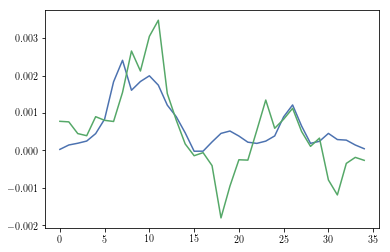

In [41]:
falpha_x_mean_norm = div0(falpha_x_mean.T, np.max(falpha_x_mean, axis=1)).T
ntp, _ = nptl_high_x.shape
nptl_high_x_latter = np.sum(nptl_high_x[1:, :].reshape(ntp-1, -1, 4), axis=2)
nptl_escape = np.zeros(nptl_high_x_latter.shape)
nptl_escape[falpha_x_mean_norm < 0.1] = nptl_high_x_latter[falpha_x_mean_norm < 0.1]
nptl_escape_tot = np.zeros(ntp)
nptl_escape_tot[1:] = np.sum(nptl_escape, axis=1)
nptl_acc = nptl_high_tot - nptl_escape_tot
esc_rate1 = div0(np.gradient(nptl_escape_tot, dtf), nptl_acc)
# img = plt.imshow(nptl_escape, cmap=plt.cm.jet,
#                  aspect='auto', origin='lower',
#                  interpolation='bicubic')
plt.plot(esc_rate[6:])
plt.plot(esc_rate1[6:])
# plt.plot(nptl_escape_tot)
# plt.plot(nptl_high_tot)
# plt.plot(nptl_high_xb)

In [42]:
# for cl in cs.collections:
#     len_max = 0
#     max_index = 0
#     for index, p in enumerate(cl.get_paths()):
#         v = p.vertices
#         if len(v) > len_max:
#             len_max = len(v)
#             max_index = index
# v = cl.get_paths()[max_index].vertices
# plt.plot(v[:, 1], v[:, 0])
# f = interpolate.interp1d(v[180:, 0], v[180:, 1])
# ynew = np.arange(12, 40, 1)
# xnew1 = np.ceil(f(ynew)).astype(int)
# plt.plot(v[180:, 1], v[180:, 0], 'o', xnew1, ynew, '-')
# f = interpolate.interp1d(v[:180, 0], v[:180, 1])
# ynew = np.arange(12, 40, 1)
# xnew2 = np.floor(f(ynew)).astype(int)
# plt.plot(v[:180, 1], v[:180, 0], 'o', xnew2, ynew, '-')

3.514012118596949


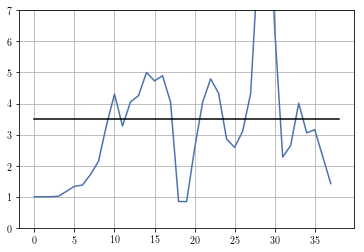

In [43]:
alpha_mean = np.mean(alpha_tot[:, eindex1:eindex2], axis=1)
# ene_tot = np.sum(alpha_tot[:, eindex1:eindex2+1] *
#                  falpha[:, 0, eindex1:eindex2+1], axis=1)
# ntot_high = np.sum(falpha[:, 0, eindex1:eindex2+1], axis=1)
# alpha_mean = ene_tot / ntot_high
# pindex = (esc_rate / alpha_mean) * ne_high_acc / ne_high_tot
pindex = div0(esc_rate[1:], alpha_mean)
pindex_mean = np.mean(pindex[10:30])
plt.plot(pindex[2:] + 1)
plt.plot([0, 38], [pindex_mean + 1, pindex_mean + 1], color='k')
plt.grid(True)
plt.ylim([0, 7])
print(pindex_mean + 1)
# esc_rate.tofile(pic_run_dir + 'agu18_data/esc_rate.dat')
# alpha_mean.tofile(pic_run_dir + 'agu18_data/alpha_mean.dat')
# ne_high_acc.tofile(pic_run_dir + 'agu18_data/ne_high_acc.dat')
# ne_high_tot.tofile(pic_run_dir + 'agu18_data/ne_high_tot.dat')

Mean value: 3.514012


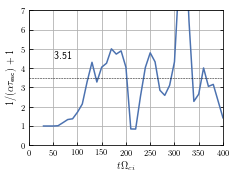

In [44]:
twci = np.linspace(10, 400, 40)
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.15, 0.15, 0.77, 0.75]
ax1 = fig.add_axes(rect1)
ax1.plot(twci[2:], pindex[2:] + 1)
pmean = np.mean(pindex[10:30] + 1)
print('Mean value: %f' % pmean)
ax1.plot([0, 400], [pmean, pmean], color='k',
         linestyle='--', linewidth=0.5)
ax1.grid(True)
ax1.set_xlim([0, 400])
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.set_xlabel(r'$t\Omega_{ci}$', fontsize=10)
ax1.set_ylabel(r'$1/(\alpha\tau_\text{esc}) + 1$', fontsize=10)
text1 = ("%0.2f" % pmean)
ax1.text(0.13, 0.7, text1,
         color='k', fontsize=10,
         bbox=dict(facecolor='none', alpha=1.0,
                   edgecolor='none', pad=10.0),
         horizontalalignment='left', verticalalignment='top',
         transform=ax1.transAxes)
ax1.set_ylim([0, 7])

fig.savefig('../img/cori_3d/pindex_bg02_e.pdf')

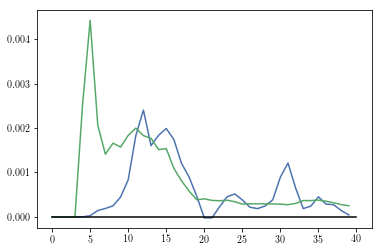

In [48]:
esc_rate[1] = 0
# alpha_real = pindex_mean * alpha_mean * ne_high_tot / ne_high_acc
alpha_real = pindex_mean * alpha_mean
p1, = plt.plot(esc_rate[1:])
# p2, = plt.plot(alpha_mean)
p3, = plt.plot(alpha_real)
p4, = plt.plot([0, 40], [0, 0], color='k')

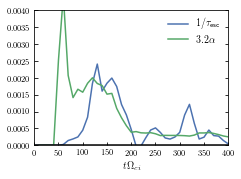

In [46]:
esc_rate[1] = 0
alpha_real = (pmean - 1) * alpha_mean
twci = np.linspace(0, 400, 41)
fig = plt.figure(figsize=[3.5, 2.5])
rect1 = [0.15, 0.15, 0.77, 0.75]
ax1 = fig.add_axes(rect1)
p1, = ax1.plot(twci, esc_rate, label=r'$1/\tau_\text{esc}$')
# p2, = plt.plot(alpha_mean)
p3, = ax1.plot(twci[1:], alpha_real, label=r'$3.2\alpha$')
p4, = ax1.plot([0, 400], [0, 0], color='k')
ax1.tick_params(bottom=True, top=False, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.tick_params(labelsize=8)
ax1.set_xlim([0, 400])
ax1.set_ylim([0, 0.004])
ax1.set_xlabel(r'$t\Omega_{ci}$', fontsize=10)
# ax1.set_ylabel(r'$1/(\alpha\tau_\text{esc}) + 1$', fontsize=10)
ax1.legend(loc=1, prop={'size': 10}, ncol=1,
           shadow=False, fancybox=False, frameon=False)

fig.savefig('../img/cori_3d/rates_bg02_e.pdf')